In [1]:
## jupyter notebook to simulate the range of the nuclear recoils in a given decay chain

import numpy as np
import matplotlib.pyplot as plt
import alpha_recoil_sim as ar
import importlib

In [2]:
## make dictionary containing decay chain information for a given list of isotopes
path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC"

iso_list = ['Ac-225', 'Pb-212', 'At-211', 'Th-227', 'Ra-223']

iso_dict = {}

for iso in iso_list:
    ciso = iso[:2].lower()
    cA = iso[-3:]
    iso_dict[iso] = ar.parse_decay_chain(path + "/decay_data/" + ciso + "_" + cA + "_decay_chain.txt")

In [3]:
## Load the Monte Carlo data from SRIM
import pickle

data_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/SRIM_Data/'

with open(data_path + 'SRIM_MC_events.pkl', 'rb') as f:
    MC_dict = pickle.load(f)

In [4]:
## Run over the isotopes and various shell materials, and save data
importlib.reload(ar)

iso_list = ['Ac-225', 'Pb-212', 'At-211', 'Th-227', 'Ra-223']
shell_mat = ['SiO2', 'Au', 'Ag']
shell_thick = [350, 100, 150]
N = 20000

out_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/SRIM_Data/'

sim_dict = {}

for iso in iso_list:
    for j,shell in enumerate(shell_mat):

        print("Working on %d events for %s with %s shell"%(N, iso, shell))

        sphere_dict = {"inner_radius": 20, "outer_shell_thick": shell_thick[j], "inner_material": "SiO2", "shell_material": shell}

        sim_dict[iso + "_" + shell] = ar.sim_N_events(N, iso, iso_dict, sphere_dict, MC_dict)

with open(data_path + 'simulation_data.pkl', 'wb') as f:
    pickle.dump(sim_dict, f)

Working on 20000 events for Ac-225 with SiO2 shell


/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC/alpha_recoil_sim.py:206: RuntimeWarning: invalid value encountered in double_scalars
  ct = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC/alpha_recoil_sim.py:211: RuntimeWarning: invalid value encountered in true_divide
  u = u / np.linalg.norm(u)   # normalize the axis vector


Working on 20000 events for Ac-225 with Au shell
Working on 20000 events for Ac-225 with Ag shell
Working on 20000 events for Pb-212 with SiO2 shell
Working on 20000 events for Pb-212 with Au shell
Working on 20000 events for Pb-212 with Ag shell
Working on 20000 events for At-211 with SiO2 shell
Working on 20000 events for At-211 with Au shell
Working on 20000 events for At-211 with Ag shell
Working on 20000 events for Th-227 with SiO2 shell
Working on 20000 events for Th-227 with Au shell
Working on 20000 events for Th-227 with Ag shell
Working on 20000 events for Ra-223 with SiO2 shell
Working on 20000 events for Ra-223 with Au shell
Working on 20000 events for Ra-223 with Ag shell


Found 34 bad points out of 20000: 0.170%
Found 12 bad points out of 20000: 0.060%
Found 8 bad points out of 20000: 0.040%
Found 26 bad points out of 20000: 0.130%
Found 25 bad points out of 20000: 0.125%
Found 14 bad points out of 20000: 0.070%
Found 9 bad points out of 20000: 0.045%
Found 22 bad points out of 20000: 0.110%
Found 10 bad points out of 20000: 0.050%
Found 21 bad points out of 20000: 0.105%
Found 14 bad points out of 20000: 0.070%
Found 15 bad points out of 20000: 0.075%
Found 20 bad points out of 20000: 0.100%
Found 12 bad points out of 20000: 0.060%
Found 14 bad points out of 20000: 0.070%


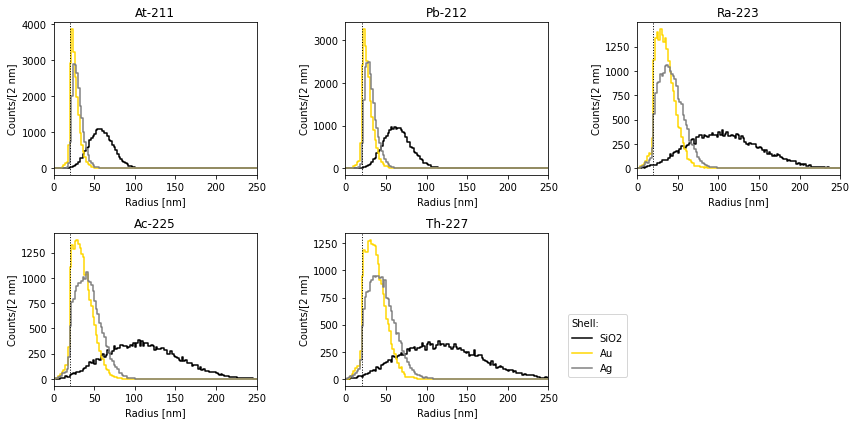

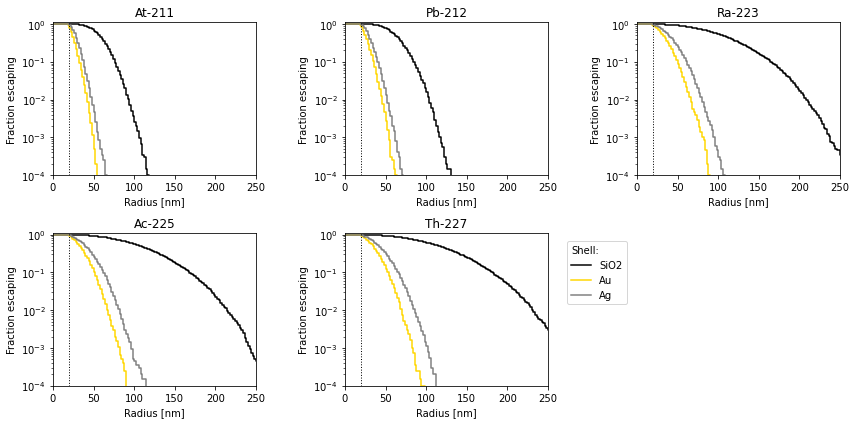

In [79]:
# Make a plot of the final position distribution and escape fraction for each isotope
col_list = ['k', 'gold', 'gray']
importlib.reload(ar)

thresh_list = [0.5, 0.1, 0.01, 0.001]
sty = ['-', '--', ':']

fig_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/plots/'

df = plt.figure(facecolor='white', figsize=(12,6))
sf = plt.figure(facecolor='white', figsize=(12,6))
idx = 1

thickness_dict = {}

for iso in iso_list:
    for j,shell in enumerate(shell_mat):

        x, y, s = ar.analyze_simulation( sim_dict[iso + "_" + shell] )
        plt.figure(df.number)
        plt.subplot(2,3,idx)
        plt.step(x,y,color=col_list[j],where='mid', label=shell)
        plt.xlabel("Radius [nm]")
        plt.ylabel("Counts/[2 nm]")
        plt.xlim(0,250)

        plt.figure(sf.number)
        plt.subplot(2,3,idx)
        plt.step(x,s,color=col_list[j],where='mid', label=shell)
        plt.xlabel("Radius [nm]")
        plt.ylabel("Fraction escaping")
        plt.xlim(0,250)

        thick = np.interp(thresh_list, s[::-1], x[::-1])
        thickness_dict[iso + "_" + shell] = thick

    plt.figure(df.number)
    yy = plt.ylim()
    rin = sphere_dict['inner_radius']
    plt.plot([rin, rin], yy, 'k:', lw=1)
    plt.ylim(yy)
    plt.title(iso)

    plt.figure(sf.number)
    plt.gca().set_yscale('log')
    yy = [1e-4, 1.1]
    rin = sphere_dict['inner_radius']
    plt.plot([rin, rin], yy, 'k:', lw=1)
    plt.ylim(yy)
    plt.title(iso)

    idx +=1

plt.figure(df.number)
#df.subplots_adjust(hspace=0.4)
leg=plt.legend(bbox_to_anchor=(1.07, 0.5), title="Shell:")
leg._legend_box.align = "left"
plt.tight_layout()
plt.savefig(fig_path + "range_vs_iso.pdf")

plt.figure(sf.number)
#sf.subplots_adjust(hspace=0.4)
leg = plt.legend(bbox_to_anchor=(1.07, 0.5), title="Shell:")
leg._legend_box.align = "left"
plt.tight_layout()
plt.savefig(fig_path + "escape_vs_iso.pdf")


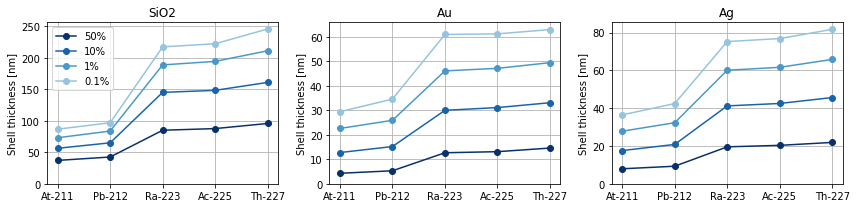

In [80]:
## plot fraction escaping versus iso and thickness

plt.figure(facecolor='white', figsize=(12,3))

iso_list = ['At-211', 'Pb-212', 'Ra-223', 'Ac-225', 'Th-227']

cmap = plt.get_cmap('Blues_r')
n=6
colors = [cmap(i/(n-1)) for i in range(n)] 

rin = sphere_dict['inner_radius']

for j,shell in enumerate(shell_mat):
    
    plt.subplot(1,3,j+1)

    thick_dat = []
    for iso in iso_list:
        
        cdat = thickness_dict[iso + "_" + shell]

        thick_dat.append(cdat)

    thick_dat = np.array(thick_dat)
    for k in range(np.shape(thick_dat)[1]):
        plt.plot( thick_dat[:,k]-rin, '-o', color=colors[k], label="%g%%"%(thresh_list[k]*100))
    yy = plt.ylim()
    plt.ylim([0,yy[1]])
    ax = plt.gca()
    ax.set_xticks(range(len(iso_list)))
    ax.set_xticklabels(iso_list)
    plt.ylabel("Shell thickness [nm]")

    if(j == 0):
        [plt.legend()]

    plt.grid(True)

    plt.title(shell)
    plt.tight_layout()
    plt.savefig(fig_path + "shell_vs_escape.pdf")

Found 14 bad points out of 20000: 0.070%


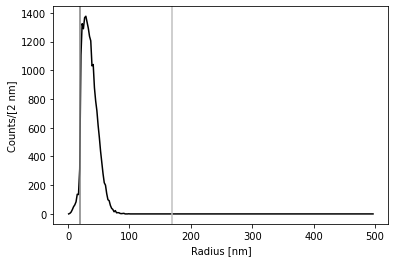

In [5]:
importlib.reload(ar)
ar.analyze_simulation(sim_dict['Ac-225_Au'], sphere_dict)

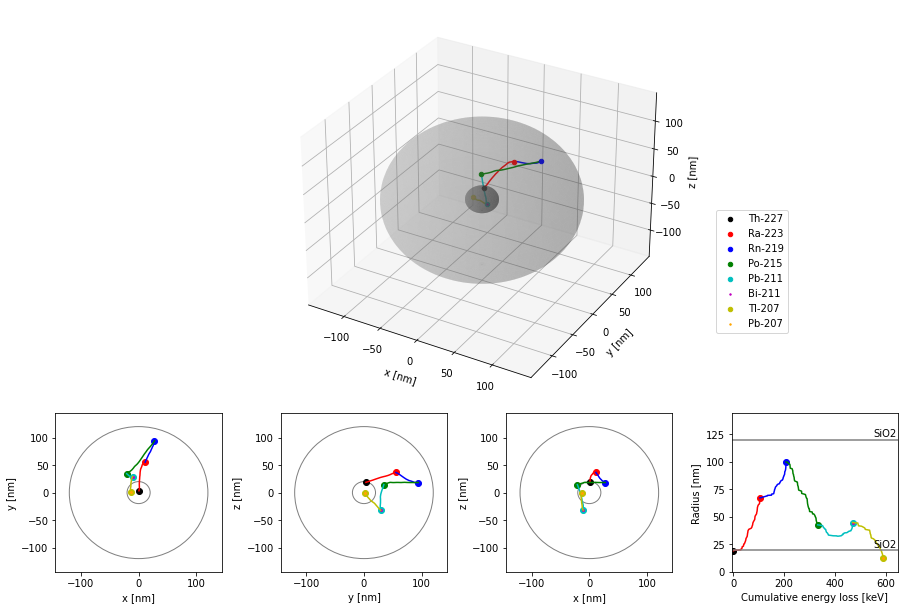

In [463]:
importlib.reload(ar)
ar.plot_event(out[211], sphere_dict)